In [1]:
%matplotlib inline
import sys
import numpy as np
sys.path.append("../")
sys.path.append("../models/")
sys.path.append("../objectives/")
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
import torch
import time

In [2]:
## Load dataset
data_path = "../../BBs"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()

NUM_DATASETS, PIXELS, _ = OB.shape
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 200
NUM_HIDDEN = 32
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')

PATH = 'bb-test'

In [3]:
from decoder import *
dec_x = Dec_x(2, NUM_HIDDEN, PIXELS*PIXELS)
if CUDA:
    dec_x.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(dec_x.parameters()), lr=LEARNING_RATE, betas=(0.9, 0.99))

In [15]:
img = OB[0].data.numpy()
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

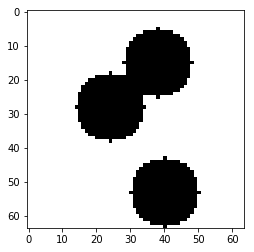

In [36]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='Greys')

In [21]:
import torch.nn.functional as F

In [9]:
def stn_to_pixel_coord(scale, translation, length):
    size = (length + 1.) * scale
    shift = 0.5 * (length - 1.) * (translation - scale + 1.)
    return shift, size

def stn_to_pixel_coords(stn_coords, img_size):

    if not isinstance(stn_coords, tf.Tensor):
        stn_coords = np.asarray(stn_coords)

    sx, sy, tx, ty = ops.split(stn_coords, 4, axis=-1)
    y, h = stn_to_pixel_coord(sy, ty, img_size[0])
    x, w = stn_to_pixel_coord(sx, tx, img_size[1])

    coords = ops.concat((y, x, h, w), -1)
    return coords

In [29]:
sx = 0.5
sy = 0.5
tx = 0.0
ty = 0.0
M = torch.Tensor([[sx, 0, tx], [0, sy, ty]])
M

tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000]])

In [33]:
tensor_img =  torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0)
output_grid = F.affine_grid(M.unsqueeze(0),tensor_img.size())
output_img = F.grid_sample(tensor_img, output_grid)

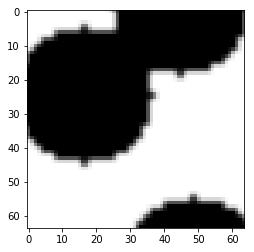

In [37]:
plt.imshow(output_img.squeeze(0).squeeze(0).data.numpy(),  cmap='Greys')

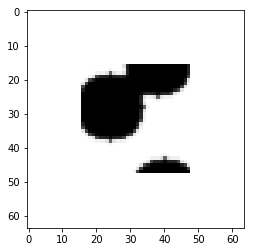

In [38]:
sx = 2.0
sy = 2.0
tx = 0.0
ty = 0.0
M2 = torch.Tensor([[sx, 0, tx], [0, sy, ty]])
output_grid2 = F.affine_grid(M2.unsqueeze(0),output_img.size())
output_img2 = F.grid_sample(output_img, output_grid2)
plt.imshow(output_img2.squeeze(0).squeeze(0).data.numpy(),  cmap='Greys')

In [43]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices].view(-1, PIXELS*PIXELS)
        mu = MU[batch_indices]
#         ob_embedding = torch.cat((ob, mu), -1)

#         ob_embedding = shuffler(ob_embedding)
        if CUDA:
            ob = ob.cuda().to(DEVICE)
            mu = mu.cuda().to(DEVICE)
        p = dec_x(ob, mu)
        loss =  - p['images'].log_prob.sum()
#         ## gradient step
        loss.backward()
        optimizer.step()  
        LOSS += loss
    time_end = time.time()
    print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))

epoch=0, loss=1070.1749 (1s)
epoch=1, loss=1080.0215 (1s)
epoch=2, loss=1066.7126 (1s)
epoch=3, loss=1082.7164 (1s)
epoch=4, loss=1071.0841 (1s)
epoch=5, loss=1052.9937 (1s)
epoch=6, loss=1051.1300 (1s)
epoch=7, loss=1051.6011 (1s)
epoch=8, loss=1033.0900 (1s)
epoch=9, loss=1033.6683 (1s)
epoch=10, loss=1038.8698 (1s)
epoch=11, loss=1041.7010 (1s)
epoch=12, loss=1033.7491 (1s)
epoch=13, loss=1025.7493 (1s)
epoch=14, loss=1024.7188 (1s)
epoch=15, loss=1019.7283 (1s)
epoch=16, loss=1017.1339 (1s)
epoch=17, loss=1020.6430 (1s)
epoch=18, loss=1018.5601 (1s)
epoch=19, loss=1011.3444 (1s)
epoch=20, loss=1022.2507 (1s)
epoch=21, loss=1000.6223 (1s)
epoch=22, loss=1012.7358 (1s)
epoch=23, loss=995.1825 (1s)
epoch=24, loss=1010.5485 (1s)
epoch=25, loss=1014.7056 (1s)
epoch=26, loss=997.3070 (1s)
epoch=27, loss=994.7328 (1s)
epoch=28, loss=989.7005 (1s)
epoch=29, loss=988.0460 (1s)
epoch=30, loss=986.7252 (1s)
epoch=31, loss=981.4836 (1s)
epoch=32, loss=989.2015 (1s)
epoch=33, loss=981.4700 (1s)

KeyboardInterrupt: 

In [44]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices].view(-1, PIXELS*PIXELS)
mu = MU[batch_indices]
ob = ob.cuda().to(DEVICE)
mu = mu.cuda().to(DEVICE)
recon_mu = dec_x.recon_mu(mu).view(-1, PIXELS, PIXELS)

In [45]:
recon_mu.shape

torch.Size([20, 64, 64])

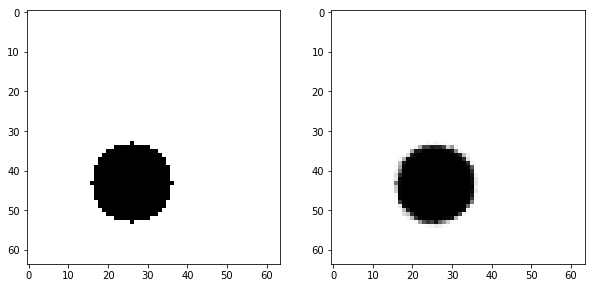

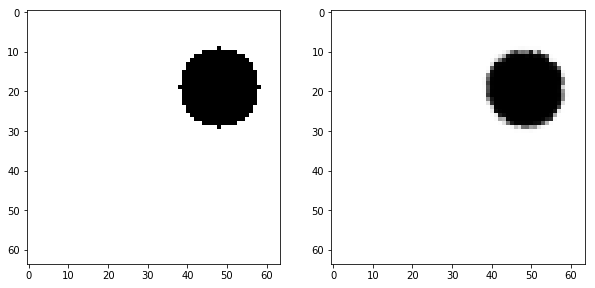

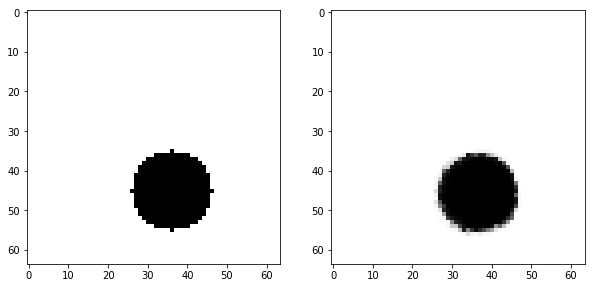

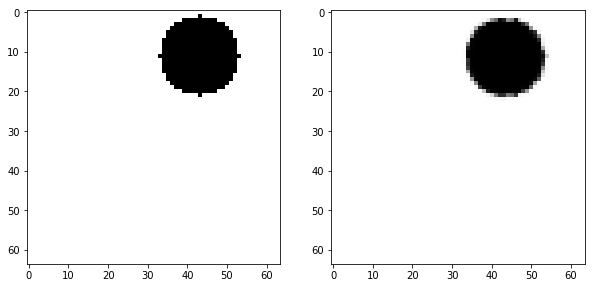

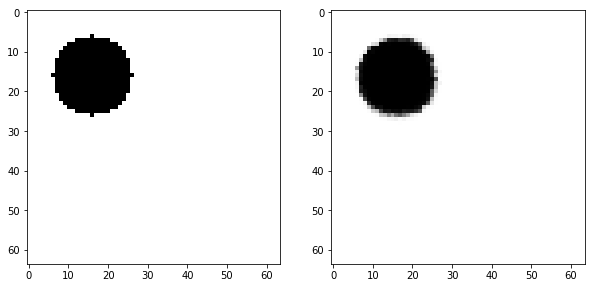

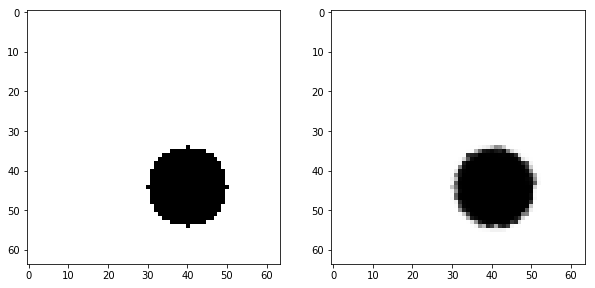

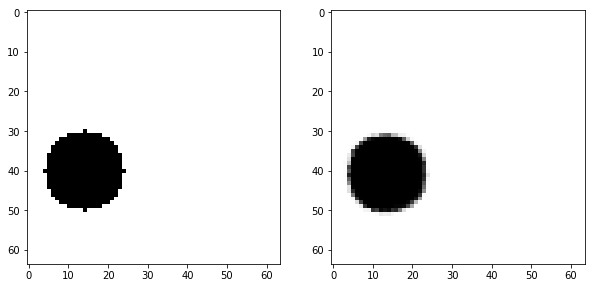

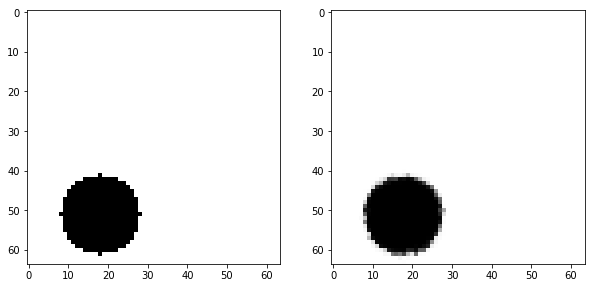

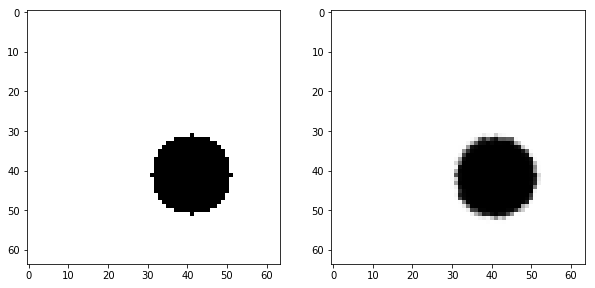

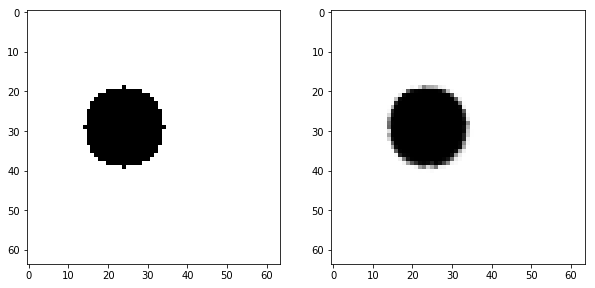

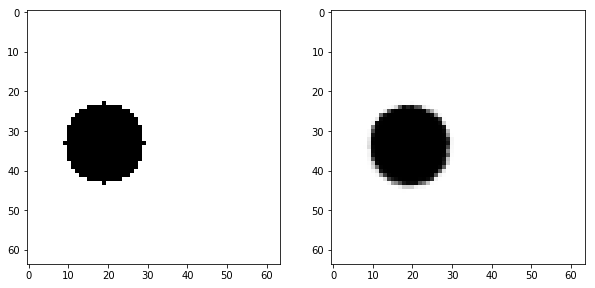

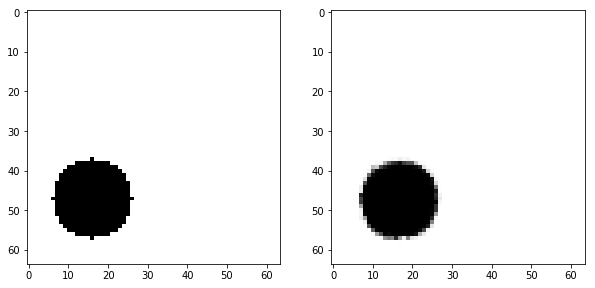

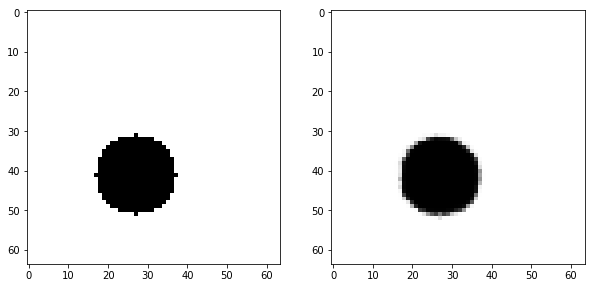

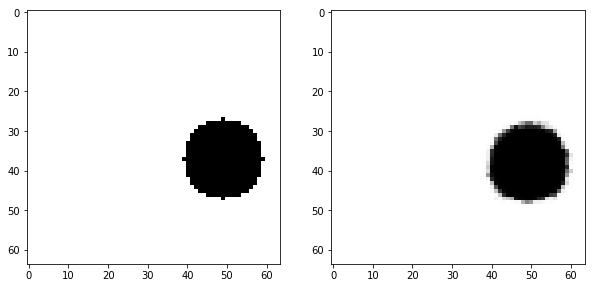

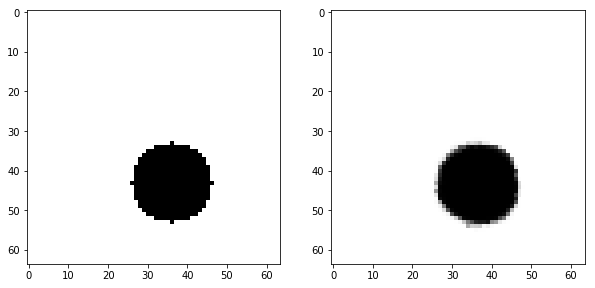

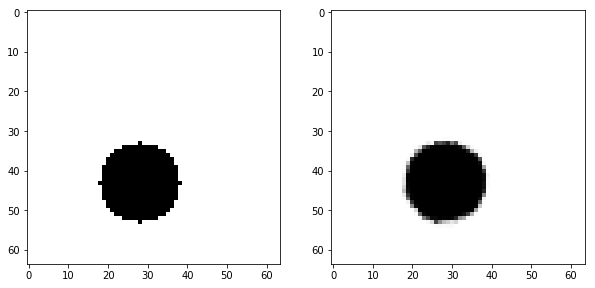

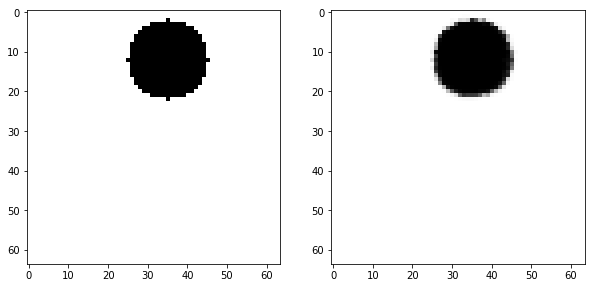

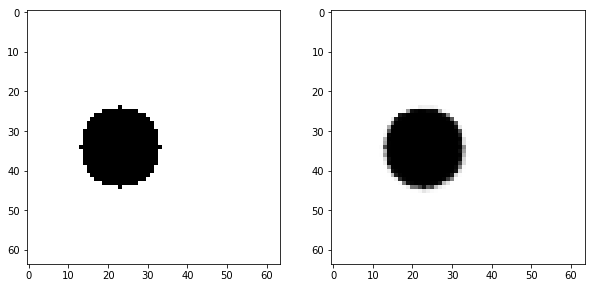

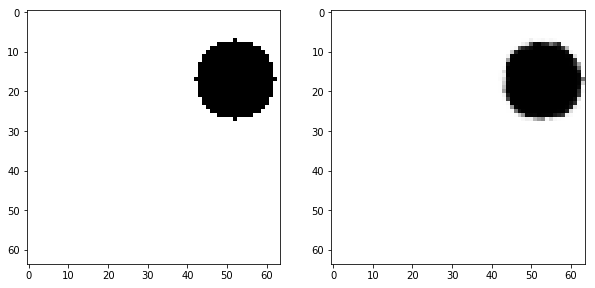

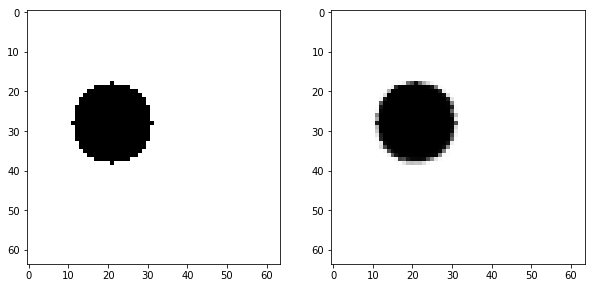

In [46]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
for i in range(BATCH_SIZE):
    fig = plt.figure(figsize=(10, 5))
    img = ob[i].view(PIXELS, PIXELS).cpu().data.numpy()
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img, cmap='Greys')
    recon = recon_mu[i].cpu().data.numpy()
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(recon, cmap='Greys')

In [33]:
img.shape

(1, 64, 64)